# Taller Clase 5: Detección de Objetos - EfficientNet

Modelo: EfficientNet-B0/B3 como extractor de características CONGELADO

**Estructura del Taller**:
- 1. Descargar dataset y etiquetas en imágenes (x_top, y_top)
- 3. Modelo: Extractor de características + Cabeza (regresión de 4 variables)
- 4. Entrenamiento
    - 4.1 Visualizar resultados entrenamiento
- 5. Evaluación
- 6. Predicciones evaluación

**Características:**
- Backbone: EfficientNet-B0/B3 pre-entrenado en ImageNet (CONGELADO)
- Parámetros: EfficientNet-B0: ~5M (congelados), Solo cabeza: ~2M (entrenables)
- Ventajas: eficiente, mejor rendimiento por parámetro, SiLU activation, ENTRENAMIENTO RÁPIDO
- Desventajas: Más complejo de entender



In [1]:
# Importar las clases del módulo
from bounding_box_efficientnet import (
    BoundingBoxDataset, 
    EfficientNetBoundingBoxRegressor, 
    WeightedMSELoss,
    load_dataset,
    train_model,
    plot_training_results,
    evaluate_model_detailed,
    print_evaluation_results,
    visualize_predictions
)
from show_annotation import show_annotation  

import torch
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

# Configuración del modelo EfficientNet OPTIMIZADO
MODEL_NAME = "EfficientNet-B0"  # Cambiar a "EfficientNet-B3" si quieres usar EfficientNet-B3
BATCH_SIZE = 32  # Batch size más grande porque es más rápido
LEARNING_RATE = 1e-3  # Learning rate más alto porque solo entrena la cabeza
EPOCHS = 20  # Menos épocas porque converge más rápido
PATIENCE = 8  # Menos paciencia porque converge más rápido
MIN_DELTA = 1e-4

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"🖥️ Dispositivo: {device}")
print(f"📊 Configuración OPTIMIZADA:")
print(f"   - Modelo: {MODEL_NAME}")
print(f"   - Batch Size: {BATCH_SIZE}")
print(f"   - Learning Rate: {LEARNING_RATE}")
print(f"   - Épocas: {EPOCHS}")
print(f"   - Early Stopping: {PATIENCE} épocas")
print(f"   - BACKBONE CONGELADO: Solo entrena la cabeza de predicción")


🖥️ Dispositivo: cpu
📊 Configuración OPTIMIZADA:
   - Modelo: EfficientNet-B0
   - Batch Size: 32
   - Learning Rate: 0.001
   - Épocas: 20
   - Early Stopping: 8 épocas
   - BACKBONE CONGELADO: Solo entrena la cabeza de predicción
🖥️ Dispositivo: cpu
📊 Configuración OPTIMIZADA:
   - Modelo: EfficientNet-B0
   - Batch Size: 32
   - Learning Rate: 0.001
   - Épocas: 20
   - Early Stopping: 8 épocas
   - BACKBONE CONGELADO: Solo entrena la cabeza de predicción


## 1. Descargar dataset y etiquetas en imágenes (x_top, y_top)


In [2]:
# Cargar dataset
image_paths, annotation_paths = load_dataset()

# Transformaciones MEJORADAS
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Crear dataset
dataset = BoundingBoxDataset(image_paths, annotation_paths, transform=transform)

# Dividir dataset
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])

# Crear DataLoaders
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

print(f"📊 División del dataset:")
print(f"   - Entrenamiento: {len(train_dataset)} muestras")
print(f"   - Validación: {len(val_dataset)} muestras")


📁 Dataset cargado: 6209 muestras
📂 Categorías: 102
📊 División del dataset:
   - Entrenamiento: 4967 muestras
   - Validación: 1242 muestras


Claves disponibles en anotación: ['__header__', '__version__', '__globals__', 'box_coord', 'obj_contour']
box_coord shape: (1, 4), contenido: [[ 44 201  18 260]]
obj_contour shape: (2, 42)


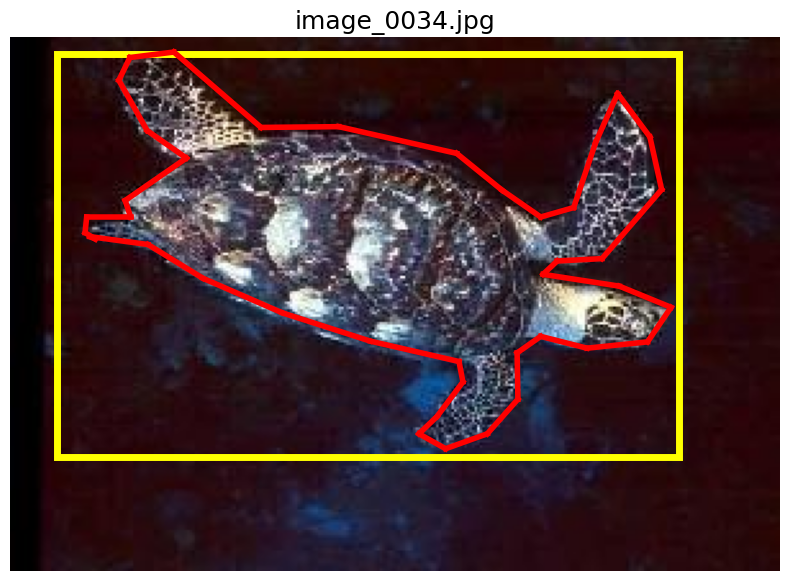

In [23]:
idx = np.random.randint(0, len(image_paths))
# Mostrar la anotación
show_annotation(image_paths[idx], annotation_paths[idx])

## 3. Modelo: Extractor de características + Cabeza (regresión de 4 variables)


In [24]:
# Crear modelo
backbone = 'efficientnet_b0' if MODEL_NAME == 'EfficientNet-B0' else 'efficientnet_b3'
model = EfficientNetBoundingBoxRegressor(backbone=backbone)
model = model.to(device)

# Contar parámetros entrenables vs congelados
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
frozen_params = total_params - trainable_params

print(f"🤖 Modelo {MODEL_NAME} OPTIMIZADO creado:")
print(f"   - Parámetros totales: {total_params:,}")
print(f"   - Parámetros CONGELADOS (backbone): {frozen_params:,}")
print(f"   - Parámetros ENTRENABLES (cabeza): {trainable_params:,}")
print(f"   - Ratio entrenables: {trainable_params/total_params*100:.1f}%")

# Configurar entrenamiento OPTIMIZADO - Solo parámetros entrenables
criterion = WeightedMSELoss()
optimizer = optim.AdamW(model.parameters(), lr=LEARNING_RATE, weight_decay=1e-4)  # Solo parámetros entrenables
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=EPOCHS, eta_min=1e-6)  # Cosine annealing

print(f"⚙️ Configuración de entrenamiento OPTIMIZADA:")
print(f"   - Función de pérdida: WeightedMSE (pesos: {criterion.weights})")
print(f"   - Optimizador: AdamW (lr={LEARNING_RATE}, weight_decay=1e-4)")
print(f"   - Scheduler: CosineAnnealingLR")
print(f"   - Solo entrena: {trainable_params:,} parámetros")


🤖 Modelo EfficientNet-B0 OPTIMIZADO creado:
   - Parámetros totales: 5,979,520
   - Parámetros CONGELADOS (backbone): 4,007,548
   - Parámetros ENTRENABLES (cabeza): 1,971,972
   - Ratio entrenables: 33.0%
⚙️ Configuración de entrenamiento OPTIMIZADA:
   - Función de pérdida: WeightedMSE (pesos: tensor([1., 1., 1., 1.]))
   - Optimizador: AdamW (lr=0.001, weight_decay=1e-4)
   - Scheduler: CosineAnnealingLR
   - Solo entrena: 1,971,972 parámetros


## 4. Entrenamiento


In [25]:
# Entrenar
train_losses, val_losses = train_model(
    model, train_loader, val_loader, criterion, optimizer, scheduler, 
    EPOCHS, device, patience=PATIENCE, min_delta=MIN_DELTA
)


🚀 Iniciando entrenamiento OPTIMIZADO de EfficientNet-B0 por 20 épocas con early stopping (patience=8)
⚡ OPTIMIZACIÓN: Solo entrena la cabeza de predicción (backbone congelado)
Epoch   1/20 | Train Loss: 0.0759 | Val Loss: 0.0343 | LR: 9.94e-04 | Patience: 0/8
Epoch   2/20 | Train Loss: 0.0382 | Val Loss: 0.0326 | LR: 9.76e-04 | Patience: 0/8
Epoch   3/20 | Train Loss: 0.0349 | Val Loss: 0.0328 | LR: 9.46e-04 | Patience: 1/8
Epoch   4/20 | Train Loss: 0.0322 | Val Loss: 0.0307 | LR: 9.05e-04 | Patience: 0/8
Epoch   5/20 | Train Loss: 0.0306 | Val Loss: 0.0302 | LR: 8.54e-04 | Patience: 0/8
Epoch   6/20 | Train Loss: 0.0293 | Val Loss: 0.0289 | LR: 7.94e-04 | Patience: 0/8
Epoch   7/20 | Train Loss: 0.0276 | Val Loss: 0.0281 | LR: 7.27e-04 | Patience: 0/8
Epoch   8/20 | Train Loss: 0.0260 | Val Loss: 0.0294 | LR: 6.55e-04 | Patience: 1/8
Epoch   9/20 | Train Loss: 0.0253 | Val Loss: 0.0279 | LR: 5.79e-04 | Patience: 0/8
Epoch  10/20 | Train Loss: 0.0238 | Val Loss: 0.0280 | LR: 5.01e-04 

### 4.1 Visualizar resultados entrenamiento


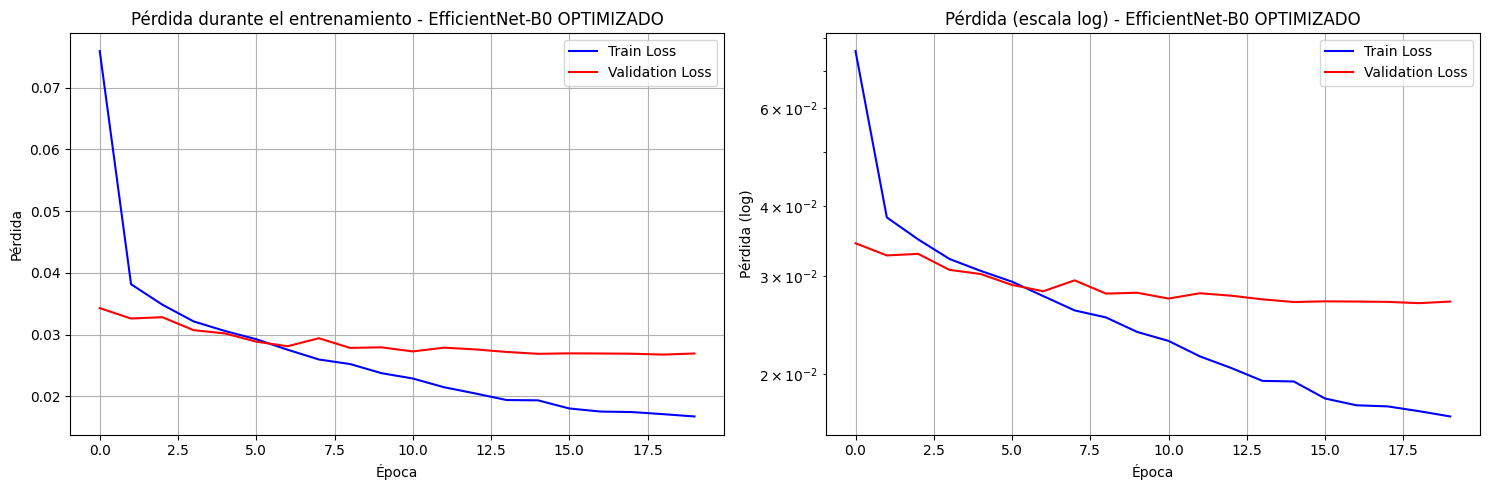

📊 Resultados finales de EfficientNet-B0 OPTIMIZADO:
   - Pérdida final de entrenamiento: 0.0168
   - Pérdida final de validación: 0.0270
   - Mejor pérdida de validación: 0.0268


In [26]:
# Visualizar resultados del entrenamiento
plot_training_results(train_losses, val_losses)

print(f"📊 Resultados finales de {MODEL_NAME} OPTIMIZADO:")
print(f"   - Pérdida final de entrenamiento: {train_losses[-1]:.4f}")
print(f"   - Pérdida final de validación: {val_losses[-1]:.4f}")
print(f"   - Mejor pérdida de validación: {min(val_losses):.4f}")


## 5. Evaluación


In [27]:
# Evaluar
print(f"🔍 Evaluando el modelo {MODEL_NAME} OPTIMIZADO...")
evaluation_results = evaluate_model_detailed(model, val_loader, device)
print_evaluation_results(evaluation_results)


🔍 Evaluando el modelo EfficientNet-B0 OPTIMIZADO...
\n📊 Resultados de evaluación - EfficientNet-B0 OPTIMIZADO:
   - MSE: 0.006734
   - RMSE: 0.082062
   - MAE: 0.060396
\n📏 Error absoluto medio por coordenada:
   - x_left: 0.061232
   - y_top: 0.057922
   - x_right: 0.059561
   - y_bottom: 0.062868
\n📈 Error promedio: 6.04% de las coordenadas normalizadas


## 6. Predicciones evaluación


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].


🎨 Visualizando predicciones del modelo EfficientNet-B0...


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].


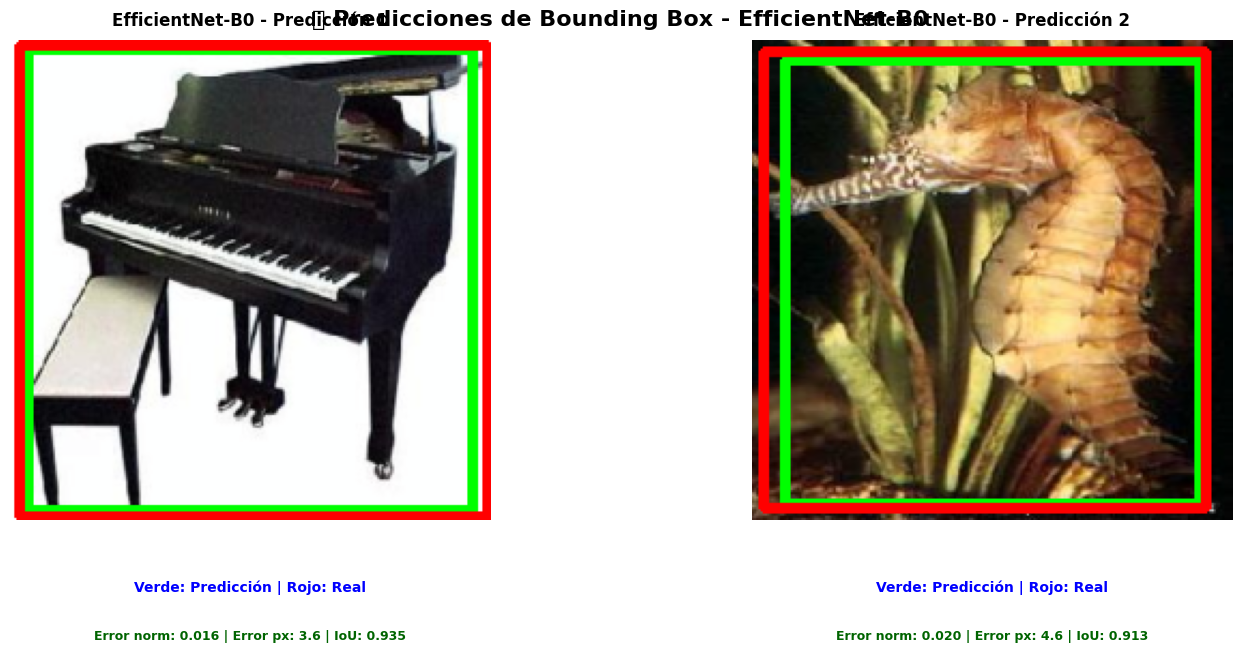

In [5]:
# Visualizar predicciones
print(f"🎨 Visualizando predicciones del modelo {MODEL_NAME}...")
visualize_predictions(model, val_dataset, num_samples=2, device=device)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].


🎨 Visualizando predicciones del modelo EfficientNet-B0...


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].


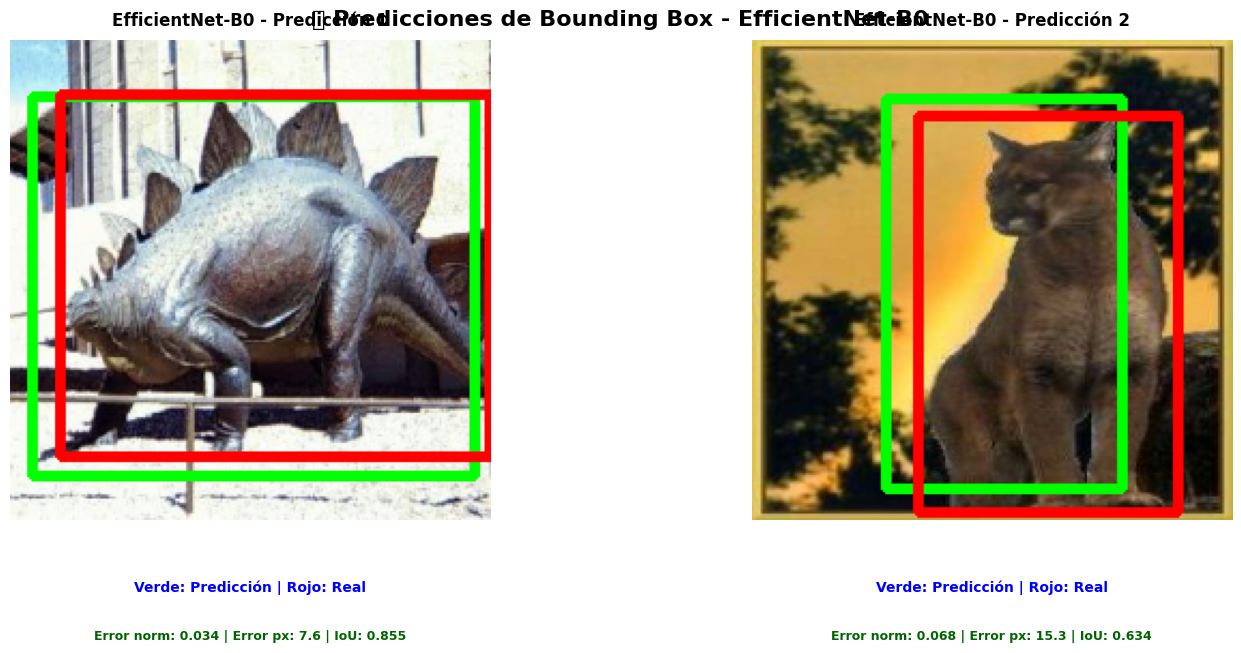

In [6]:
# Visualizar predicciones
print(f"🎨 Visualizando predicciones del modelo {MODEL_NAME}...")
visualize_predictions(model, val_dataset, num_samples=2, device=device)

In [29]:
# Guardar modelo
from datetime import datetime
import os

model_dir = "models"
if not os.path.exists(model_dir):
    os.makedirs(model_dir)

timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
model_name_file = f"{MODEL_NAME.lower().replace('-', '_')}_bounding_box_model_OPTIMIZADO_{timestamp}.pth"
model_path = os.path.join(model_dir, model_name_file)

torch.save({
    'model_state_dict': model.state_dict(),
    'model_architecture': f'EfficientNetBoundingBoxRegressor_{backbone}_OPTIMIZADO',
    'backbone': MODEL_NAME,
    'num_classes': 4,
    'epochs_trained': len(train_losses),
    'final_train_loss': train_losses[-1],
    'final_val_loss': val_losses[-1],
    'best_val_loss': min(val_losses),
    'evaluation_results': evaluation_results,
    'optimizations_applied': [
        'Formato correcto de coordenadas [y1,y2,x1,x2] -> [x1,y1,x2,y2]',
        'Normalización correcta',
        'Visualización completamente corregida',
        'BACKBONE CONGELADO - Solo entrena la cabeza',
        'Configuración de entrenamiento optimizada',
        'Learning rate más alto (1e-3) para cabeza sola',
        'Menos épocas (20) porque converge más rápido',
        'Batch size más grande (32)',
        'Entrenamiento mucho más rápido'
    ],
    'parameters_info': {
        'total_params': total_params,
        'frozen_params': frozen_params,
        'trainable_params': trainable_params,
        'trainable_ratio': trainable_params/total_params
    }
}, model_path)

print(f"💾 Modelo {MODEL_NAME} OPTIMIZADO guardado exitosamente:")
print(f"   - Archivo: {model_path}")
print(f"   - Épocas entrenadas: {len(train_losses)}")
print(f"   - Mejor pérdida de validación: {min(val_losses):.4f}")
print(f"   - Error promedio: {evaluation_results['mae'] * 100:.2f}%")
print(f"   - Parámetros entrenables: {trainable_params:,} ({trainable_params/total_params*100:.1f}%)")


💾 Modelo EfficientNet-B0 OPTIMIZADO guardado exitosamente:
   - Archivo: models/efficientnet_b0_bounding_box_model_OPTIMIZADO_20251027_140120.pth
   - Épocas entrenadas: 20
   - Mejor pérdida de validación: 0.0268
   - Error promedio: 6.04%
   - Parámetros entrenables: 1,971,972 (33.0%)


In [3]:
# Cargar modelo específico guardado
import os
model_dir = "models"
model_name_file = "efficientnet_b0_bounding_box_model_OPTIMIZADO_20251027_140120.pth"
model_path = os.path.join(model_dir, model_name_file)

# Verificar si el archivo existe
if os.path.exists(model_path):
    print(f"📂 Cargando modelo específico:")
    
    # Cargar el checkpoint con weights_only=False para evitar el error de seguridad
    checkpoint = torch.load(model_path, map_location=device, weights_only=False)
    
    # Crear el modelo con la misma arquitectura
    backbone = 'efficientnet_b0'
    model_loaded = EfficientNetBoundingBoxRegressor(backbone=backbone)
    model_loaded = model_loaded.to(device)
    
    # Cargar los pesos del modelo
    model_loaded.load_state_dict(checkpoint['model_state_dict'])
    model_loaded.eval()  # Modo evaluación
    
    print(f"✅ Modelo cargado exitosamente")
   
    # Usar el modelo cargado para predicciones
    model = model_loaded

📂 Cargando modelo específico:
✅ Modelo cargado exitosamente
